# TD - Clustering

Ce répertoire contient les fichiers et solutions pour le TD Clustering.  
**Fait par : CHICA Miller et TORRES Jonathan**

Le TD est composé de trois exercices principaux :

1. **Clustering K-Means**  
   Analyse de clusters avec différentes valeurs de k pour observer la séparation des pays selon leur niveau de développement.

2. **Clustering hiérarchique**  
   Utilisation de l’implémentation SciPy pour générer des dendrogrammes à partir de matrices de similarité et de distance, en comparant les méthodes **single link** et **complete link**.

3. **Etude de cas**  
   Étude des résultats obtenus avec K-Means et le clustering hiérarchique, identification des patterns et discussion sur la pertinence des regroupements.



## 1. Clustering k-means

### Exercice 1

In [1]:
from typing import List, Optional
import math, random
from copy import deepcopy

# Définition d'un type pour représenter un point (liste de coordonnées numériques)
Point = List[float]

# Fonction pour calculer la distance euclidienne au carré entre deux points
def euclidean_sq(p: Point, q: Point) -> float:
    return sum((pi - qi) ** 2 for pi, qi in zip(p, q))

# Fonction pour calculer le centre (moyenne) d’un ensemble de points
def mean_point(points: List[Point]) -> Point:
    dim = len(points[0])
    return [sum(p[d] for p in points) / len(points) for d in range(dim)]

# Implémentation de l’algorithme k-means
def kmeans(
    data: List[Point],            # Jeu de données : liste de points
    k: int,                       # Nombre de clusters
    init_centroids: Optional[List[Point]] = None,  # Centroïdes initiaux (optionnel)
    max_iter: int = 100,          # Nombre maximal d’itérations
    tol: float = 0.0,             # Tolérance sur le déplacement des centroïdes
    seed: Optional[int] = None,   # Graine aléatoire (pour la reproductibilité)
    verbose: bool = True          # Si True, affiche les itérations
) -> float:
    # Vérifie que le jeu de données n’est pas vide
    if not data:
        if verbose:
            print("Fin clustering, erreur = 0.0")
        return 0.0

    n = len(data)
    if k <= 0 or k > n:
        raise ValueError("k doit être compris entre 1 et len(data)")

    # Vérifie que tous les points ont la même dimension
    dim = len(data[0])
    for p in data:
        if len(p) != dim:
            raise ValueError("Tous les points doivent avoir la même dimension")

    # Initialisation aléatoire des centroïdes si aucun n’est fourni
    rng = random.Random(seed)
    if init_centroids is None:
        centroids = [deepcopy(p) for p in rng.sample(data, k)]
    else:
        if len(init_centroids) != k:
            raise ValueError("init_centroids doit contenir exactement k centroïdes")
        centroids = [list(map(float, c)) for c in init_centroids]

    # Tableau pour mémoriser les affectations (cluster de chaque point)
    assignments = [-1] * n

    # Boucle principale : assignation et mise à jour
    for it in range(1, max_iter + 1):
        changed = False
        clusters = [[] for _ in range(k)]

        # Étape d’assignation : chaque point est affecté au centroïde le plus proche
        for i, p in enumerate(data):
            dists = [euclidean_sq(p, c) for c in centroids]
            j = min(range(k), key=lambda idx: dists[idx])
            if assignments[i] != j:
                changed = True
                assignments[i] = j
            clusters[j].append(p)

        # Affichage de l’état actuel (si verbose=True)
        if verbose:
            print(f"Iteration {it}")
            for j in range(k):
                c_str = "[" + ", ".join(f"{x:.10g}" for x in centroids[j]) + "]"
                print(f"Centroid {c_str} Points {clusters[j]}")

        # Étape de mise à jour : recalcul des centroïdes comme moyennes des clusters
        new_centroids = deepcopy(centroids)
        for j in range(k):
            if clusters[j]:
                new_centroids[j] = mean_point(clusters[j])
            else:
                # Si un cluster est vide, on conserve l’ancien centroïde
                new_centroids[j] = centroids[j]

        # Calcul du déplacement maximal des centroïdes
        max_move = max(
            math.sqrt(euclidean_sq(old, new))
            for old, new in zip(centroids, new_centroids)
        )
        centroids = new_centroids

        # Condition d’arrêt : aucune affectation ne change ou déplacement < tol
        if not changed or max_move <= tol:
            break

    # Calcul de l’erreur finale (SSE : somme des distances au carré)
    sse = 0.0
    for p, j in zip(data, assignments):
        sse += euclidean_sq(p, centroids[j])

    # Affichage du résultat final
    if verbose:
        print(f"Fin clustering, erreur = {sse}")
    return sse

In [2]:
# === Tests avec le jeu de données de l’énoncé ===
data1 = [[1], [2], [18], [20], [31]]

print("=== Init [[1],[2],[18]] ===")
kmeans(data1, k=3, init_centroids=[[1], [2], [18]], tol=0.0, verbose=True)

print("\n=== Init [[18],[20],[31]] ===")
kmeans(data1, k=3, init_centroids=[[18], [20], [31]], tol=0.0, verbose=True)

=== Init [[1],[2],[18]] ===
Iteration 1
Centroid [1] Points [[1]]
Centroid [2] Points [[2]]
Centroid [18] Points [[18], [20], [31]]
Iteration 2
Centroid [1] Points [[1]]
Centroid [2] Points [[2]]
Centroid [23] Points [[18], [20], [31]]
Fin clustering, erreur = 98.0

=== Init [[18],[20],[31]] ===
Iteration 1
Centroid [18] Points [[1], [2], [18]]
Centroid [20] Points [[20]]
Centroid [31] Points [[31]]
Iteration 2
Centroid [7] Points [[1], [2]]
Centroid [20] Points [[18], [20]]
Centroid [31] Points [[31]]
Iteration 3
Centroid [1.5] Points [[1], [2]]
Centroid [19] Points [[18], [20]]
Centroid [31] Points [[31]]
Fin clustering, erreur = 2.5


2.5

### Exercice 2

In [3]:
# Jeu de données 1D pour le test (Exercice 2)
data2 = [[2], [4], [6], [12], [24], [30]]

print("=== (a) Centroides initiaux [[2], [6]] ===")
sse_a = kmeans(data2, k=2, init_centroids=[[2], [6]], tol=0.0, verbose=True)

print("\n=== (b) Centroides initiaux [[12], [24]] ===")
sse_b = kmeans(data2, k=2, init_centroids=[[12], [24]], tol=0.0, verbose=True)

# Affichage des erreurs finales pour le compte rendu
print("\n--- Récapitulatif ---")
print(f"SSE (a) init [[2],[6]]  = {sse_a}")
print(f"SSE (b) init [[12],[24]] = {sse_b}")

=== (a) Centroides initiaux [[2], [6]] ===
Iteration 1
Centroid [2] Points [[2], [4]]
Centroid [6] Points [[6], [12], [24], [30]]
Iteration 2
Centroid [3] Points [[2], [4], [6]]
Centroid [18] Points [[12], [24], [30]]
Iteration 3
Centroid [4] Points [[2], [4], [6], [12]]
Centroid [22] Points [[24], [30]]
Iteration 4
Centroid [6] Points [[2], [4], [6], [12]]
Centroid [27] Points [[24], [30]]
Fin clustering, erreur = 74.0

=== (b) Centroides initiaux [[12], [24]] ===
Iteration 1
Centroid [12] Points [[2], [4], [6], [12]]
Centroid [24] Points [[24], [30]]
Iteration 2
Centroid [6] Points [[2], [4], [6], [12]]
Centroid [27] Points [[24], [30]]
Fin clustering, erreur = 74.0

--- Récapitulatif ---
SSE (a) init [[2],[6]]  = 74.0
SSE (b) init [[12],[24]] = 74.0


Pour le jeu de données 1D **[[2], [4], [6], [12], [24], [30]]**, deux configurations de centroïdes initiaux ont été testées :

* (a) **[[2], [6]]**

* (b) **[[12], [24]]**

Dans les deux cas, l’algorithme converge vers le même résultat :
les points **[2], [4], [6], [12]** forment le premier cluster (centre ≈ 6),
les points **[24], [30]** le second **(centre ≈ 27)**,
avec une SSE = **74.0**.

Les deux initialisations donnent donc la même qualité de clustering,
mais la configuration (b) converge plus rapidement car ses centroïdes initiaux sont plus proches de la solution optimale.

### Exercice 3

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
from typing import List, Optional, Tuple, Dict
import math, random
from copy import deepcopy
import matplotlib.pyplot as plt

# =============================
#   1) K-means avec "history"
# =============================

Point = List[float]

def euclidean_sq(p: Point, q: Point) -> float:
    """Distance euclidienne au carré (pas de racine, plus rapide et suffisant pour argmin / SSE)."""
    return sum((pi - qi) ** 2 for pi, qi in zip(p, q))

def mean_point(points: List[Point]) -> Point:
    """Moyenne composante par composante."""
    dim = len(points[0])
    return [sum(p[d] for p in points) / len(points) for d in range(dim)]

def kmeans_with_history(
    data: List[Point],
    k: int,
    init_centroids: Optional[List[Point]] = None,
    max_iter: int = 100,
    tol: float = 0.0,
    seed: Optional[int] = None,
    verbose: bool = True
) -> Tuple[float, List[Dict]]:
    """
    K-means (points R^d) + enregistrement de l'historique.
    Retourne (SSE finale, history), où history est une liste d'états par itération :
      {"centroids": [[...], ...], "clusters": List[List[Point]], "assignments": List[int]}
    """
    if not data:
        if verbose:
            print("Fin clustering, erreur = 0.0")
        return 0.0, []

    n = len(data)
    if k <= 0 or k > n:
        raise ValueError("k doit être compris entre 1 et len(data)")

    dim = len(data[0])
    for p in data:
        if len(p) != dim:
            raise ValueError("Tous les points doivent avoir la même dimension")

    rng = random.Random(seed)
    if init_centroids is None:
        centroids = [deepcopy(p) for p in rng.sample(data, k)]
    else:
        if len(init_centroids) != k:
            raise ValueError("init_centroids doit contenir exactement k centroïdes")
        centroids = [list(map(float, c)) for c in init_centroids]

    assignments = [-1] * n
    history = []

    for it in range(1, max_iter + 1):
        changed = False
        clusters = [[] for _ in range(k)]

        # Étape d’assignation
        for i, p in enumerate(data):
            dists = [euclidean_sq(p, c) for c in centroids]
            j = min(range(k), key=lambda idx: dists[idx])
            if assignments[i] != j:
                changed = True
                assignments[i] = j
            clusters[j].append(p)

        # Sauvegarde de l'état courant
        history.append({
            "centroids": deepcopy(centroids),
            "clusters": deepcopy(clusters),
            "assignments": assignments[:],
        })

        # Affichage (comme dans l’énoncé)
        if verbose:
            print(f"Iteration {it}")
            for j in range(k):
                c_str = "[" + ", ".join(f"{x:.10g}" for x in centroids[j]) + "]"
                print(f"Centroid {c_str} Points {clusters[j]}")

        # Étape de mise à jour
        new_centroids = deepcopy(centroids)
        for j in range(k):
            if clusters[j]:
                new_centroids[j] = mean_point(clusters[j])
            else:
                new_centroids[j] = centroids[j]

        # Critère d’arrêt
        max_move = max(
            math.sqrt(euclidean_sq(old, new))
            for old, new in zip(centroids, new_centroids)
        )
        centroids = new_centroids
        if not changed or max_move <= tol:
            break

    # SSE finale
    sse = 0.0
    for p, j in zip(data, assignments):
        sse += euclidean_sq(p, centroids[j])

    if verbose:
        print(f"Fin clustering, erreur = {sse}")

    return sse, history


# ======================================
#   2) Visualisation 2D par itérations
# ======================================

def plot_sequence_2d(
    data: List[Point],
    names: List[str],
    history: List[Dict],
    title_prefix: str = "",
    xlim: Tuple[float, float] = (-3, 3),
    ylim: Tuple[float, float] = (-3, 3),
    show_axes_zero: bool = True
):
    """
    Génére une figure par itération :
    - Points (•) en 2D, étiquetés avec leurs noms.
    - Centroïdes (×) avec la même couleur que leurs clusters.
    - Même cluster => même couleur.
    """
    # Palette simple (bleu, rouge, vert, violet, orange, etc.)
    palette = ["tab:blue", "tab:red", "tab:green", "tab:purple", "tab:orange", "tab:brown"]

    for t, state in enumerate(history, start=1):
        centroids = state["centroids"]
        assignments = state["assignments"]
        k = len(centroids)

        plt.figure(figsize=(4.5, 4.5))

        # Axes + croix à (0,0) pour rappeler l’origine (comme l’illustration du sujet)
        if show_axes_zero:
            plt.axhline(0, linewidth=1, color="#87CEFA")
            plt.axvline(0, linewidth=1, color="#87CEFA")

        # Tracer les points par cluster
        for j in range(k):
            color = palette[j % len(palette)]
            # Points appartenant au cluster j
            xs = [p[0] for p, a in zip(data, assignments) if a == j]
            ys = [p[1] for p, a in zip(data, assignments) if a == j]
            labels = [nm for nm, a in zip(names, assignments) if a == j]

            plt.scatter(xs, ys, s=45, color=color)  # points (•)
            # Annotation des points
            for x, y, lab in zip(xs, ys, labels):
                plt.text(x + 0.05, y + 0.05, lab, fontsize=10, color=color)

            # Centroïde du cluster j (×)
            cx, cy = centroids[j]
            plt.scatter([cx], [cy], marker="x", s=100, linewidths=2.0, color=color)

        plt.xlim(*xlim)
        plt.ylim(*ylim)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(f"{title_prefix} - Iteration {t}")
        plt.tight_layout()
        # Pour enregistrer :
        # plt.savefig(f"{title_prefix.replace(' ', '_').lower()}_{t:02d}.png", dpi=150)
        plt.show()

=== Cas A : init M1 et M2 ===
Iteration 1
Centroid [-2, 3] Points [[-2, 3]]
Centroid [-2, 1] Points [[-2, 1], [-2, -1], [2, -1], [2, 1], [1, 0]]
Iteration 2
Centroid [-2, 3] Points [[-2, 3], [-2, 1]]
Centroid [0.2, 0] Points [[-2, -1], [2, -1], [2, 1], [1, 0]]
Iteration 3
Centroid [-2, 2] Points [[-2, 3], [-2, 1]]
Centroid [0.75, -0.25] Points [[-2, -1], [2, -1], [2, 1], [1, 0]]
Fin clustering, erreur = 15.5


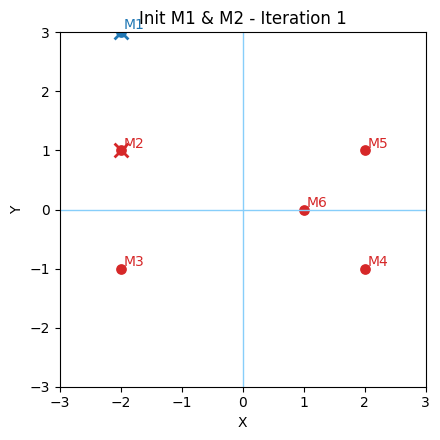

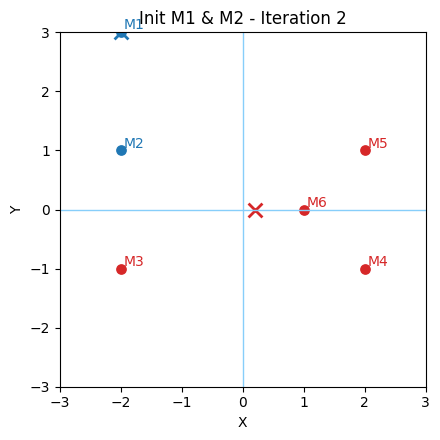

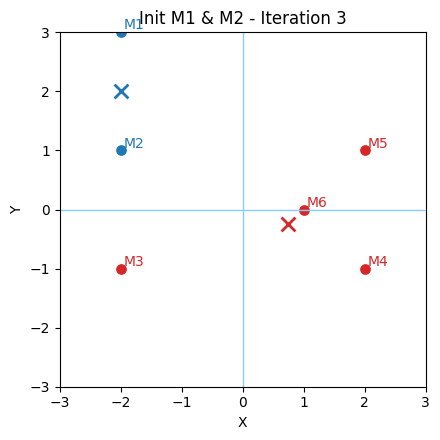


=== Cas B : init M4 et M6 ===
Iteration 1
Centroid [2, -1] Points [[2, -1]]
Centroid [1, 0] Points [[-2, 3], [-2, 1], [-2, -1], [2, 1], [1, 0]]
Iteration 2
Centroid [2, -1] Points [[2, -1], [2, 1], [1, 0]]
Centroid [-0.6, 0.8] Points [[-2, 3], [-2, 1], [-2, -1]]
Iteration 3
Centroid [1.666666667, 0] Points [[2, -1], [2, 1], [1, 0]]
Centroid [-2, 1] Points [[-2, 3], [-2, 1], [-2, -1]]
Fin clustering, erreur = 10.666666666666666


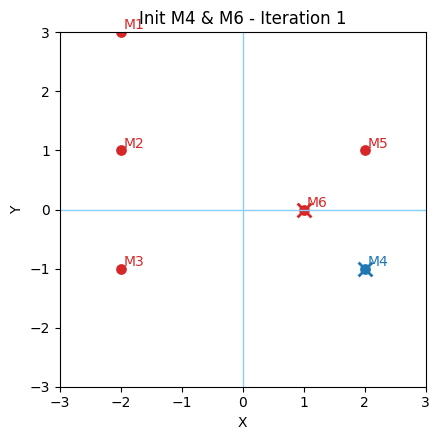

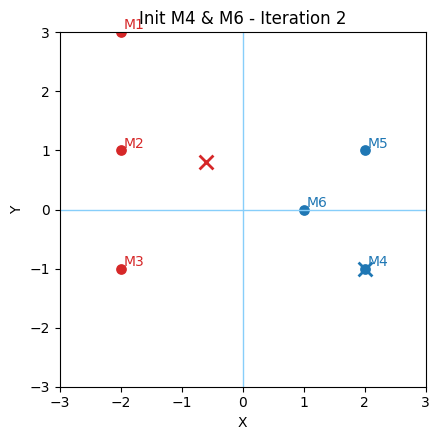

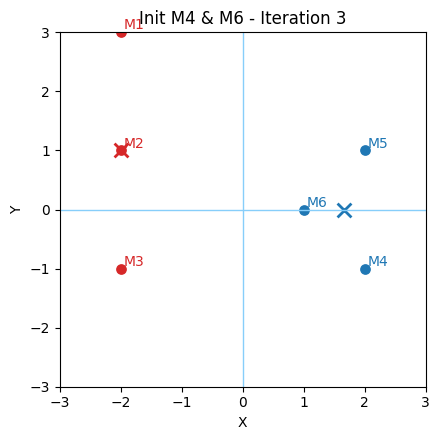


SSE A (M1,M2): 15.5
SSE B (M4,M6): 10.666666666666666


In [6]:
# ===========================
#   3) Données + Lancements
# ===========================

# Jeu de données 2D (dans l'ordre M1..M6)
names = ["M1", "M2", "M3", "M4", "M5", "M6"]
data2d = [
    [-2,  3],  # M1
    [-2,  1],  # M2
    [-2, -1],  # M3
    [ 2, -1],  # M4
    [ 2,  1],  # M5
    [ 1,  0],  # M6
]

# (A) Centroides initiaux : M1 et M2
init_A = [data2d[0], data2d[1]]  # M1, M2
print("=== Cas A : init M1 et M2 ===")
sse_A, hist_A = kmeans_with_history(data2d, k=2, init_centroids=init_A, tol=0.0, verbose=True)
plot_sequence_2d(data2d, names, hist_A, title_prefix="Init M1 & M2", xlim=(-3,3), ylim=(-3,3))

# (B) Centroides initiaux : M4 et M6
init_B = [data2d[3], data2d[5]]  # M4, M6
print("\n=== Cas B : init M4 et M6 ===")
sse_B, hist_B = kmeans_with_history(data2d, k=2, init_centroids=init_B, tol=0.0, verbose=True)
plot_sequence_2d(data2d, names, hist_B, title_prefix="Init M4 & M6", xlim=(-3,3), ylim=(-3,3))

print("\nSSE A (M1,M2):", sse_A)
print("SSE B (M4,M6):", sse_B)



La fonction `kmeans_with_history` a été améliorée pour **enregistrer l’historique des affectations et des centroïdes**, ce qui permet de générer des figures 2D à chaque itération.

**Paramètres optionnels ajoutés :**

* `names` : noms des points pour les annoter.
* `title_prefix`, `xlim`, `ylim`, `show_axes_zero` : pour personnaliser l’affichage des figures.

**Reproduction des figures :**

1. Exécuter `kmeans_with_history` avec les centroïdes initiaux.
2. Passer l’historique à `plot_sequence_2d`.
3. Chaque figure montre les points (`•`) annotés, les centroïdes (`×`) et chaque cluster avec une couleur différente.

**Tests réalisés :**

* Init M1 et M2 → succession de figures montrant la formation des clusters.
* Init M4 et M6 → idem pour un autre choix de centroïdes.


### Exercice 4

In [7]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [8]:
from sklearn.cluster import KMeans
from numpy import array

data1 = [[1], [2], [18], [20], [31]]

# Caso 1: init [[1],[2],[18]]
kmeans1 = KMeans(n_clusters=3, n_init=1, init=array([[1], [2], [18]])).fit(data1)
print("Labels:", kmeans1.labels_)
print("SSE (inertia):", kmeans1.inertia_)

# Caso 2: init [[18],[20],[31]]
kmeans2 = KMeans(n_clusters=3, n_init=1, init=array([[18], [20], [31]])).fit(data1)
print("Labels:", kmeans2.labels_)
print("SSE (inertia):", kmeans2.inertia_)

Labels: [0 1 2 2 2]
SSE (inertia): 98.00000000000003
Labels: [0 0 1 1 2]
SSE (inertia): 2.5


In [9]:
from sklearn.cluster import KMeans
from numpy import array

# Dataset Ex.2
data2 = array([[2], [4], [6], [12], [24], [30]])

def show_clusters_1d(labels, data):
    # Regroupe les points par label et les affiche
    groups = {}
    for pt, lab in zip(data.tolist(), labels.tolist()):
        groups.setdefault(lab, []).append(pt)
    return {lab: groups[lab] for lab in sorted(groups)}

# (a) init [[2],[6]]
km_a = KMeans(n_clusters=2, n_init=1, init=array([[2],[6]])).fit(data2)
print("Ex2 (a) labels:", km_a.labels_.tolist())
print("Ex2 (a) SSE (inertia):", km_a.inertia_)
print("Ex2 (a) clusters:", show_clusters_1d(km_a.labels_, data2))

# (b) init [[12],[24]]
km_b = KMeans(n_clusters=2, n_init=1, init=array([[12],[24]])).fit(data2)
print("Ex2 (b) labels:", km_b.labels_.tolist())
print("Ex2 (b) SSE (inertia):", km_b.inertia_)
print("Ex2 (b) clusters:", show_clusters_1d(km_b.labels_, data2))


Ex2 (a) labels: [0, 0, 0, 0, 1, 1]
Ex2 (a) SSE (inertia): 74.0
Ex2 (a) clusters: {0: [[2], [4], [6], [12]], 1: [[24], [30]]}
Ex2 (b) labels: [0, 0, 0, 0, 1, 1]
Ex2 (b) SSE (inertia): 74.0
Ex2 (b) clusters: {0: [[2], [4], [6], [12]], 1: [[24], [30]]}


L’implémentation manuelle de `K-means` permet de voir comment les clusters et les centroïdes évoluent itérativement, tandis que SciKit-Learn effectue **exactement les mêmes calculs de manière optimisée** et renvoie directement les clusters et SSE. 

En utilisant les mêmes centroïdes initiaux, **les deux méthodes produisent les mêmes clusters.**

In [ ]:
from sklearn.cluster import KMeans
from numpy import array

# Points 2D dans l’ordre M1..M6
names = ["M1","M2","M3","M4","M5","M6"]
data2d = array([
    [-2,  3],  # M1
    [-2,  1],  # M2
    [-2, -1],  # M3
    [ 2, -1],  # M4
    [ 2,  1],  # M5
    [ 1,  0],  # M6
])

def clusters_named(labels, names):
    groups = {}
    for nm, lab in zip(names, labels.tolist()):
        groups.setdefault(lab, []).append(nm)
    return {lab: sorted(groups[lab]) for lab in sorted(groups)}

# (A) init M1 & M2
init_A = array([data2d[0], data2d[1]])  # M1, M2
km_A = KMeans(n_clusters=2, n_init=1, init=init_A).fit(data2d)
print("Ex3 (A) labels:", km_A.labels_.tolist())
print("Ex3 (A) SSE (inertia):", km_A.inertia_)
print("Ex3 (A) clusters (par noms):", clusters_named(km_A.labels_, names))

# (B) init M4 & M6
init_B = array([data2d[3], data2d[5]])  # M4, M6
km_B = KMeans(n_clusters=2, n_init=1, init=init_B).fit(data2d)
print("Ex3 (B) labels:", km_B.labels_.tolist())
print("Ex3 (B) SSE (inertia):", km_B.inertia_)
print("Ex3 (B) clusters (par noms):", clusters_named(km_B.labels_, names))

Ex3 (A) labels: [0, 0, 1, 1, 1, 1]
Ex3 (A) SSE (inertia): 15.5
Ex3 (A) clusters (par noms): {0: ['M1', 'M2'], 1: ['M3', 'M4', 'M5', 'M6']}
Ex3 (B) labels: [1, 1, 1, 0, 0, 0]
Ex3 (B) SSE (inertia): 10.666666666666666
Ex3 (B) clusters (par noms): {0: ['M4', 'M5', 'M6'], 1: ['M1', 'M2', 'M3']}


### Analyse du Clustering k-means

Pour confirmer que l’implémentation manuelle fonctionne correctement, les clusters des exercices 2 et 3 ont été réalisés en utilisant la fonction `KMeans` de SciKit-Learn avec les mêmes centroïdes initiaux. 

Les résultats obtenus sont **identiques** à ceux produits par le code, ce qui confirme que l'algorithme implémente correctement le `K-means.` 

Cette vérification montre que SciKit-Learn effectue les mêmes calculs de manière optimisée et que l'implémentation manuelle est fidèle à l’algorithme classique.

---

## 2. Clustering hiérarchique

In [11]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [12]:
data = [0.1, 0.9, 0.35, 0.8, 0.3, 0.4, 0.5, 0.6, 0.7, 0.2]

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

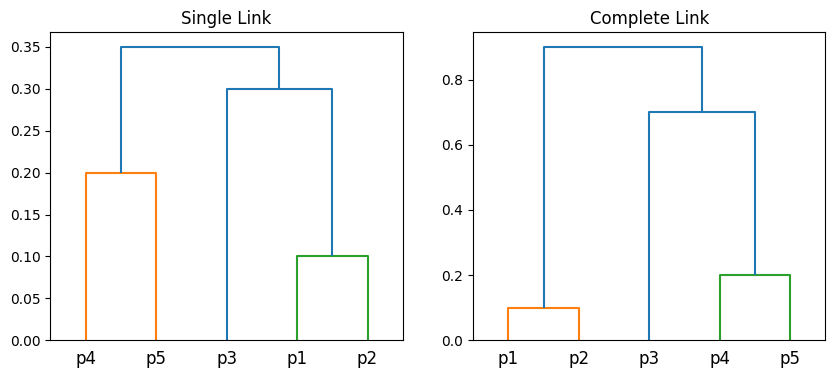

In [14]:
plt.figure(figsize=(10, 4))

# Single Linkage
plt.subplot(1, 2, 1)
Z_single = linkage(data, method='single')
dendrogram(Z_single, labels=['p1', 'p2', 'p3', 'p4', 'p5'])
plt.title("Single Link")

# Complete Linkage
plt.subplot(1, 2, 2)
Z_complete = linkage(data, method='complete')
dendrogram(Z_complete, labels=['p1', 'p2', 'p3', 'p4', 'p5'])
plt.title("Complete Link")

plt.show()

|    |  p1  |  p2  |  p3  |  p4  |  p5  |
| -- |  --- |  --- |  --- |  --- |  --- |
| p1 | 1.00 | 0.10 | 0.41 | 0.55 | 0.35 |
| p2 | 0.10 | 1.00 | 0.64 | 0.47 | 0.98 |
| p3 | 0.41 | 0.64 | 1.00 | 0.44 | 0.85 |
| p4 | 0.55 | 0.47 | 0.44 | 1.00 | 0.76 |
| p5 | 0.35 | 0.98 | 0.85 | 0.76 | 1.00 |


$$
\text{distance}(p_i, p_j) = 1 - \text{similarity}(p_i, p_j)
$$


In [15]:
similarity = [0.10, 0.41, 0.55, 0.35, 0.64, 0.47, 0.98, 0.44, 0.85, 0.76]
distance = [1 - s for s in similarity]

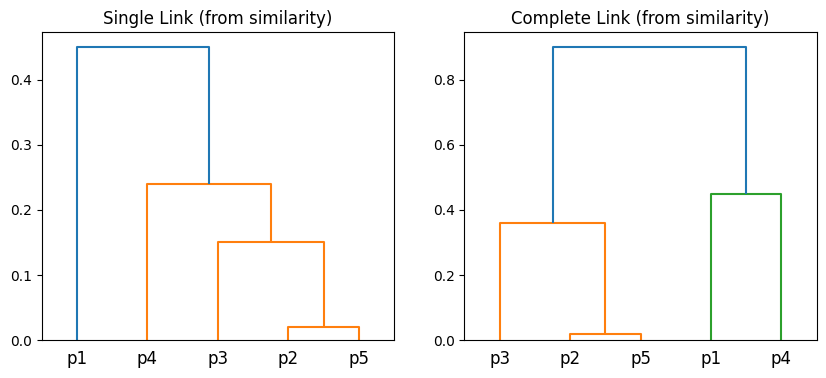

In [16]:
# Single Link
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
Z_single = linkage(distance, method='single')
dendrogram(Z_single, labels=['p1','p2','p3','p4','p5'])
plt.title("Single Link (from similarity)")

# Complete Link
plt.subplot(1, 2, 2)
Z_complete = linkage(distance, method='complete')
dendrogram(Z_complete, labels=['p1','p2','p3','p4','p5'])
plt.title("Complete Link (from similarity)")

plt.show()

### Analyse du Clustering hiérarchique


En utilisant la matrice de similarité fournie, nous avons converti les valeurs en distances selon la formule:
$$
\text{distance}(p_i, p_j) = 1 - \text{similarity}(p_i, p_j)
$$

Les résultats montrent clairement que certains points sont très proches (par exemple `p2` et `p5`, avec une distance de 0,02), tandis que d’autres sont beaucoup plus éloignés (comme `p1` et `p2`, distance 0,90). Cette transformation permet de préparer les données pour le clustering hiérarchique et d’identifier facilement les relations de proximité entre les éléments.

Le clustering hiérarchique avec le **single link** a tendance à créer des chaînes longues où les points sont ajoutés progressivement, ce qui peut rendre l’interprétation moins claire. 

En revanche, le **complete link** forme des clusters plus compacts et équilibrés, reflétant mieux la structure des données : un cluster regroupant `p3`, `p2` et `p5`, et un autre avec `p1` et `p4`. Ces résultats confirment que la méthode de liaison choisie influence fortement la visualisation et la compréhension des regroupements.

---

## 3. Etude de cas

### Préparation et PCA

Exemple de data_reduced : [[np.float64(2.9130245873965874), np.float64(-0.0956205755055116)], [np.float64(-0.42991132993193854), np.float64(0.5881556664216987)], [np.float64(0.285225077370054), np.float64(0.45517441333976766)], [np.float64(2.9324226542292737), np.float64(-1.6955550705215485)], [np.float64(-1.0335758664708325), np.float64(-0.13665870884235132)]]


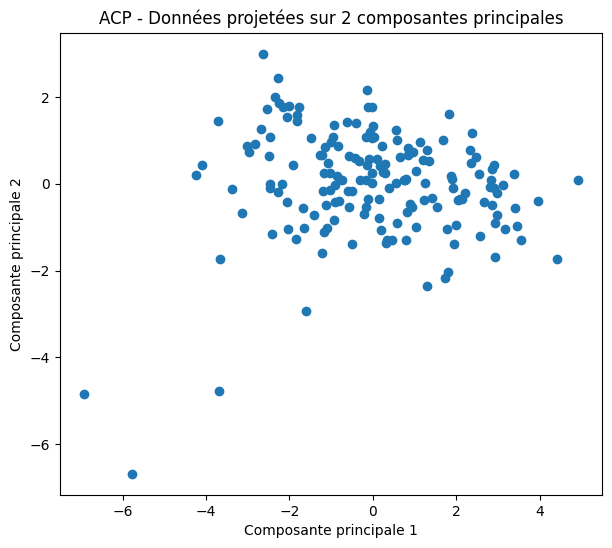

In [23]:
import csv
from numpy import array, identity, transpose, matmul, std, mean
from numpy.linalg import eig
import matplotlib.pyplot as plt

# TODO code pour lire data_country à partir du fichier Country-data.csv
countries = []
data_country = []

with open("Country-data.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # ignorer l’en-tête
    for row in reader:
        countries.append(row[0])
        data_country.append(list(map(float, row[1:])))  # convertir les 9 colonnes à float

# Les mêmes données de la matrice data_country, dans le format "array" exploitable pour la suite
X = array(data_country)

# Le nombre de points
n = len(countries)

# Le nombre de variables
p = len(data_country[0])

# La matrice des données centrées, c’est-à-dire la somme = 0 sur chaque colonne
Y = X - matmul(transpose(array([n * [1]])), transpose(array([[mean(variable)] for variable in transpose(X)])))

# La matrice des données centrées et réduites, qui en plus a l’écart type constant = 1 sur chaque colonne
Z = matmul(Y, array(list(map(lambda variable: [1. / std(variable)], transpose(X)))) * identity(p))

# La matrice (symétrique) de variance/covariance des données centrées réduites
R = matmul(matmul(transpose(Z), 1. / n * identity(n)), Z)

# Les vecteurs propres de R
eigenvectors = eig(R)[1]

# Les 2 composantes principales = 2 nouvelles variables contenant le plus d’information possible des 9 variables initiales
components = [matmul(Z, eigenvectors[:, 0]), matmul(Z, eigenvectors[:, 1])]

# La matrice initiale, projetée sur 2 nouvelles colonnes qui représentent les 2 composantes principales
data_reduced = [[components[0][i], components[1][i]] for i in range(n)]

print("Exemple de data_reduced :", data_reduced[:5])

# Visualisation ACP
plt.figure(figsize=(7, 6))
plt.scatter([x[0] for x in data_reduced], [x[1] for x in data_reduced])
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("ACP - Données projetées sur 2 composantes principales")
plt.show()

### Clustering K-Means

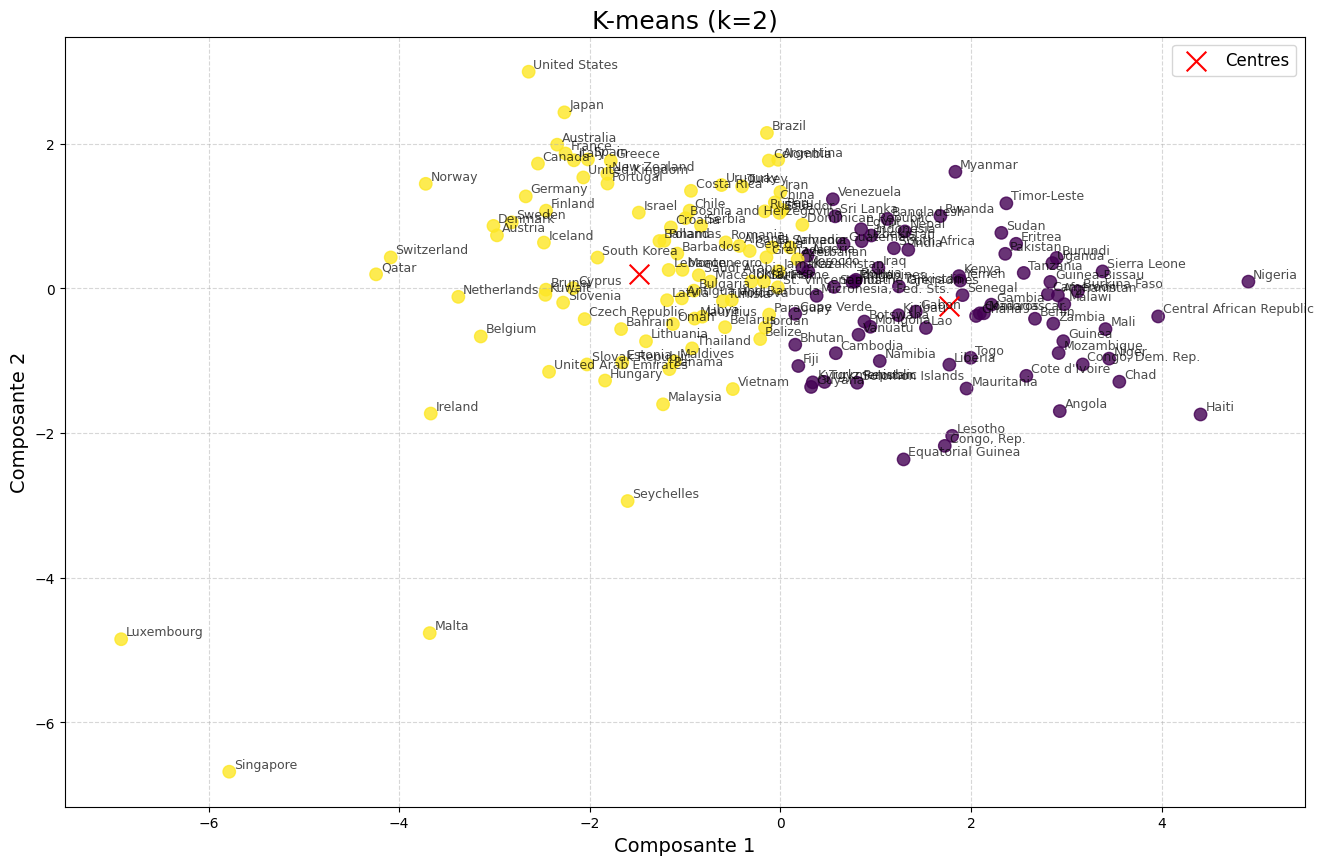

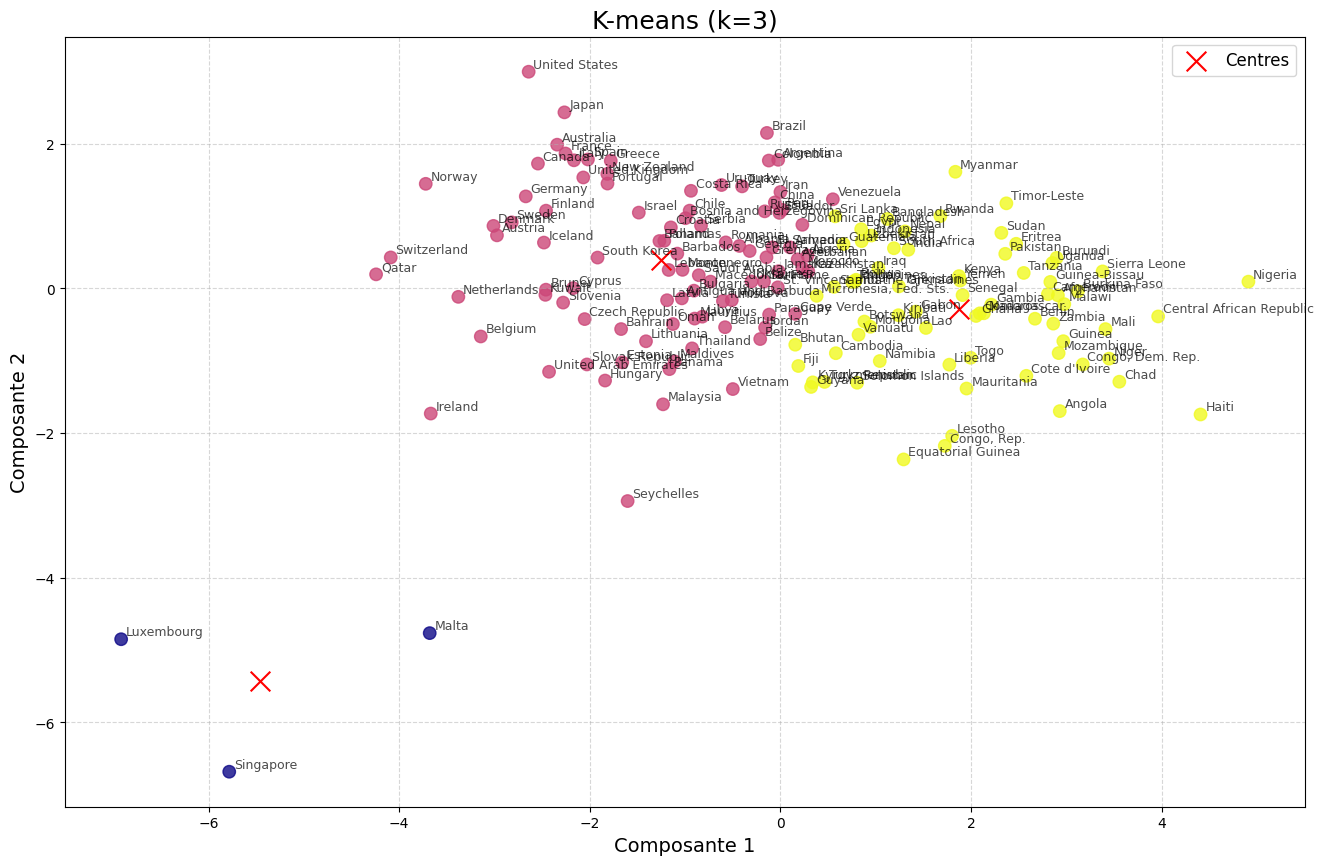

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# On travaille sur les données réduites à 2 dimensions
data_2D = np.array(data_reduced)

# === K-Means avec k = 2 ===
kmeans2 = KMeans(n_clusters=2, n_init=10, random_state=0)
labels2 = kmeans2.fit_predict(data_2D)

plt.figure(figsize=(16, 10))
plt.scatter(data_2D[:, 0], data_2D[:, 1], c=labels2, cmap="viridis", s=80, alpha=0.8)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1],
            c="red", marker="x", s=200, label="Centres")
plt.xlabel("Composante 1", fontsize=14)
plt.ylabel("Composante 2", fontsize=14)
plt.title("K-means (k=2)", fontsize=18)
plt.legend(fontsize=12)

# Ajouter les noms des pays avec un décalage
for i, country in enumerate(countries):
    plt.text(data_2D[i, 0] + 0.05, data_2D[i, 1] + 0.05, country, fontsize=9, alpha=0.7)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# === K-Means avec k = 3 ===
kmeans3 = KMeans(n_clusters=3, n_init=10, random_state=0)
labels3 = kmeans3.fit_predict(data_2D)

plt.figure(figsize=(16, 10))
plt.scatter(data_2D[:, 0], data_2D[:, 1], c=labels3, cmap="plasma", s=80, alpha=0.8)
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1],
            c="red", marker="x", s=200, label="Centres")
plt.xlabel("Composante 1", fontsize=14)
plt.ylabel("Composante 2", fontsize=14)
plt.title("K-means (k=3)", fontsize=18)
plt.legend(fontsize=12)

# Ajouter les noms des pays
for i, country in enumerate(countries):
    plt.text(data_2D[i, 0] + 0.05, data_2D[i, 1] + 0.05, country, fontsize=9, alpha=0.7)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

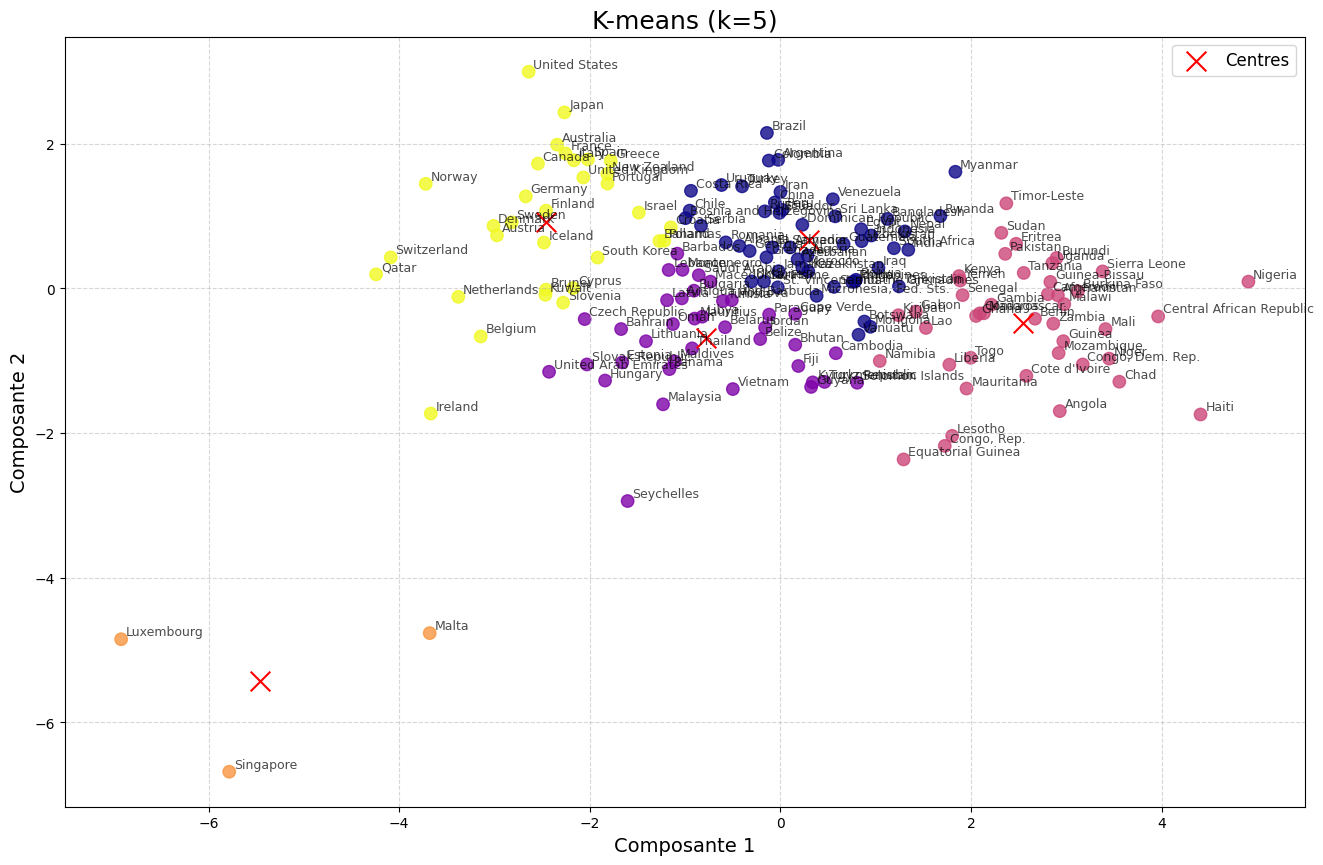

In [50]:
# === K-Means avec k = 5 ===
kmeans5 = KMeans(n_clusters=5, n_init=10, random_state=1)
labels3 = kmeans5.fit_predict(data_2D)

plt.figure(figsize=(16, 10))
plt.scatter(data_2D[:, 0], data_2D[:, 1], c=labels3, cmap="plasma", s=80, alpha=0.8)
plt.scatter(kmeans5.cluster_centers_[:, 0], kmeans5.cluster_centers_[:, 1],
            c="red", marker="x", s=200, label="Centres")
plt.xlabel("Composante 1", fontsize=14)
plt.ylabel("Composante 2", fontsize=14)
plt.title("K-means (k=5)", fontsize=18)
plt.legend(fontsize=12)

# Ajouter les noms des pays
for i, country in enumerate(countries):
    plt.text(data_2D[i, 0] + 0.05, data_2D[i, 1] + 0.05, country, fontsize=9, alpha=0.7)

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Clustering hiérarchique

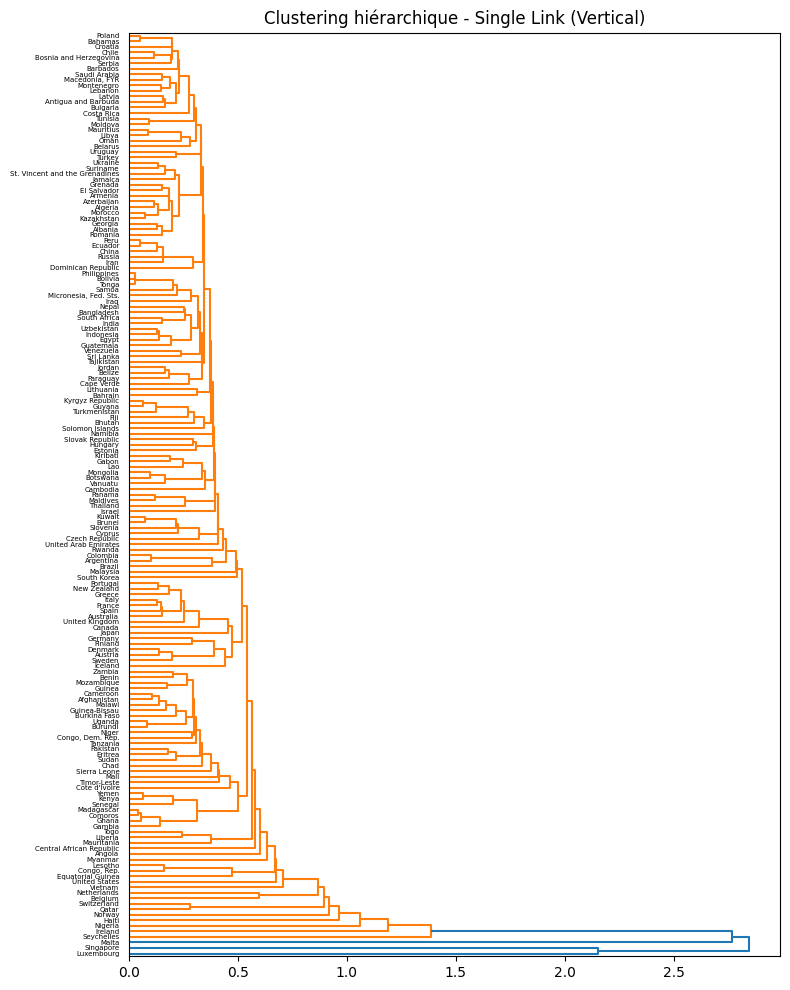

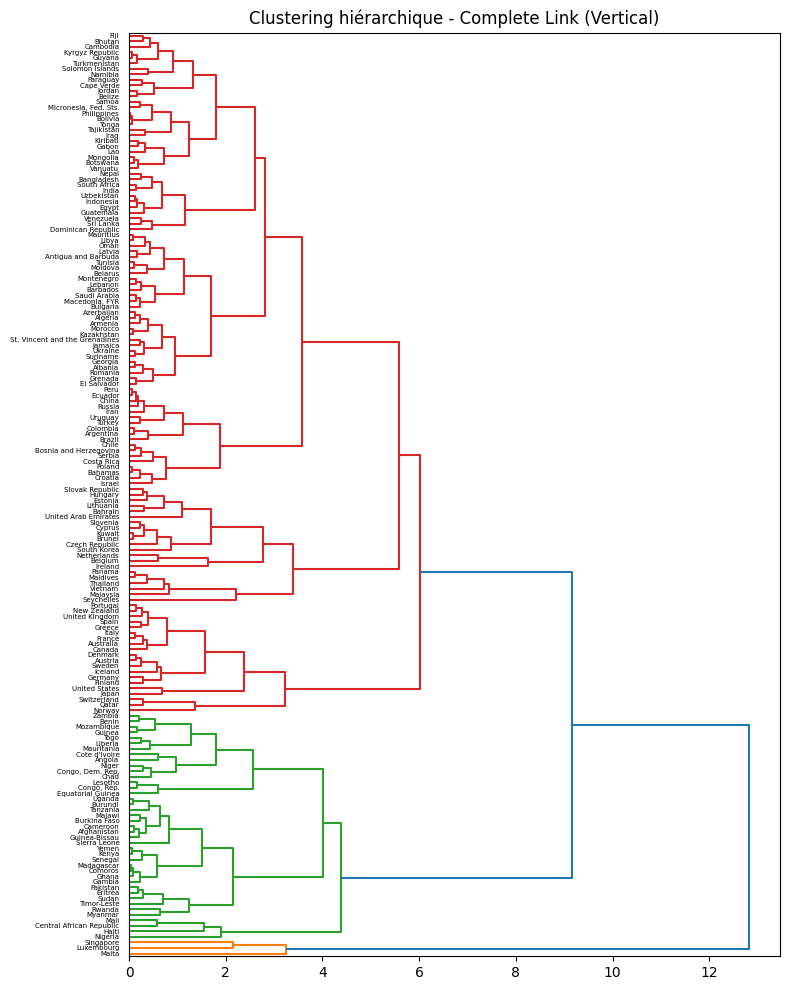

In [51]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Méthode single link
linkage_single = linkage(data_2D, method='single')
plt.figure(figsize=(8, 10))
dendrogram(linkage_single, labels=countries, orientation='right')
plt.title("Clustering hiérarchique - Single Link (Vertical)")
plt.tight_layout()
plt.show()

# Méthode complete link
linkage_complete = linkage(data_2D, method='complete')
plt.figure(figsize=(8, 10))
dendrogram(linkage_complete, labels=countries, orientation='right')
plt.title("Clustering hiérarchique - Complete Link (Vertical)")
plt.tight_layout()
plt.show()


### Analyse du Clustering sur les données Country

#### K-Means

##### Avec k = 2
On observe deux grands groupes bien distincts :  
- Le premier regroupe **les pays développés** (États-Unis, France, Allemagne, Japon, Australie, etc.), caractérisés par un PIB élevé, une faible mortalité et de bons indicateurs de santé.  
- Le second rassemble **les pays en développement** (Nigéria, Angola, Burundi, Haïti…), souvent marqués par un faible revenu et des conditions sanitaires plus précaires.  

Cette séparation reflète clairement la division économique mondiale entre le “Nord” et le “Sud”.

##### Avec k = 3
- Un troisième groupe apparaît, formé de **micro-économies très riches** comme Luxembourg, Singapour ou Malte, qui se distinguent fortement des autres pays.  
- Les deux autres clusters restent similaires : les pays industrialisés et ceux en développement.  
- Cette classification donne une vision plus nuancée, en faisant apparaître un groupe intermédiaire de pays émergents (Brésil, Chine, Afrique du Sud…).

> Note : Il est possible que des centroïdes initiaux différents modifient légèrement la frontière entre certains pays, mais la structure générale des clusters resterait la même : `pays développés`, `émergents` et en `développement`.

##### Avec k = 5

Avec cinq clusters, la segmentation devient plus fine :
on distingue non seulement les pays développés et en développement, mais aussi plusieurs sous-groupes reflétant différents niveaux économiques et sociaux.

- Un premier groupe (par exemple Luxembourg, Malte, Singapour) se situe très à part : il représente les micro-économies extrêmement riches, avec des indicateurs hors norme.
- Un deuxième cluster rassemble les pays industrialisés classiques (États-Unis, Japon, Allemagne, France…), caractérisés par un haut PIB et un bon niveau de vie.
- Un troisième groupe correspond aux pays émergents (Brésil, Chine, Afrique du Sud, etc.), avec une croissance rapide mais encore des écarts internes.
- Les deux derniers clusters regroupent les pays en développement et ceux à faible revenu, principalement en Afrique et en Asie du Sud, où les indicateurs économiques et sanitaires sont plus bas.

> Globalement, le passage à k = 5 permet de mieux capter la diversité des situations économiques mondiales.
Certaines frontières peuvent légèrement changer selon l’initialisation aléatoire, mais la structure générale reste stable :
micro-économies riches, pays développés, pays émergents, pays en développement, et pays à faible revenu.

#### Clustering hiérarchique

- **Single link (lien simple)** :  
  Tendance à créer des chaînes longues et peu équilibrées ; les pays se rassemblent progressivement sans frontières nettes entre les groupes.

- **Complete link (lien complet)** :  
  Forme des clusters plus compacts et cohérents, où les pays sont mieux séparés selon leur niveau de développement.

Dans l’ensemble, les regroupements obtenus sont logiques et confirment les résultats du K-Means :   on retrouve bien **trois grandes catégories** : pays développés, émergents et en développement.